In [1]:
%matplotlib inline

import os, shutil
import agate
from datetime import datetime
from decimal import *
from geojson import Feature, FeatureCollection, Point
import geopandas as gpd, pandas as pd

/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
/Users/brentjones/anaconda

/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/brentjones/anaconda/envs/2019-06-26-hayden/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/bre

## Import previous csv

In the import notebook, we created a csv with crime reports limited to the dates we're interested in and reprojected coordinates. First we need to import that data.

In [2]:
text_type = agate.Text()
number_type = agate.Number()
boolean_type = agate.Boolean()
datetime_type = agate.DateTime()
date_type = agate.Date()

def import_latlon_table(file):
    column_names = ['Complaint','CodedMonth','DateOccur','FlagCrime','FlagUnfounded','FlagAdministrative','Count','FlagCleanup','Crime','District','Description','ILEADSAddress','ILEADSStreet','Neighborhood','LocationName','LocationComment','CADAddress','CADStreet','XCoord','YCoord','coords','lat','lon']
    column_types = [text_type,text_type,datetime_type,boolean_type,boolean_type,boolean_type,number_type,boolean_type,text_type,text_type,text_type,text_type,text_type,text_type,text_type,text_type,text_type,text_type,number_type,number_type,text_type,number_type,number_type]

    new_table = agate.Table.from_csv(file,column_names,column_types)
    return new_table

splitLatLon = import_latlon_table('temp/with_lat_lon.csv')


## Clean up the crime column

The files were not exported consistently. Needing to analyze by crime, we need to make sure that column is consistent. It should be six digits long, and some of the codes would have a leading zero. Because it was treated as a number at some point before export, the leading zero has been dropped. There is also varying white space.

Here we standardize this column to a string, strip any whitespace and add the leading zero back in where it was lost.

It will also be useful to have a list of these codes and what they mean. So we can generate a list of unique codes and their descriptions, outputting that to a separate file.

In [3]:
class cleanCrime(agate.Computation):
    def get_computed_data_type(self, table):
        return agate.Text()
    
    def run(self, table):
        new_column = []
        
        for index,row in enumerate(table.rows):
            if len(row['Crime'].strip()) == 5:
                new = '0' + row['Crime'].strip()
                new_column.append(new)
            else:
                new_column.append(row['Crime'])
                
                
        return new_column
    
cleaned = splitLatLon.compute([
    ('cleanCrime', cleanCrime())
])

crime_lookup = cleaned.select(['cleanCrime', 'Description']).distinct('cleanCrime').order_by('cleanCrime')

crime_lookup.to_csv('temp/crime_lookup.csv')

## Are the coordinates ok?

One of the biggest questions with this data is if the coordinates are accurate/usable for what we're doing. If, for example, all reports with unknown coordinates were given coordinates that matched police HQ, that would make using the coordinates for analysis more difficult.

So, we can do some testing to see if we can rely on these.

A few questions to answer:

* How many rows don't have coordinates?
* Of rows with coordinates, are there clusters where we might not expect them?
* Of rows without coordinates, if there are addresses available, are there clusters?
* Are particular crimes over- or under-represented in rows without coordinates?

In [4]:
class concatAddress(agate.Computation):
    def get_computed_data_type(self, table):
        return agate.Text()
    
    def run(self, table):
        new_column = []
        
        for index,row in enumerate(table.rows):
#             if index % 100 == 0:
#                 print('Row: {} of {}'.format(index,len(table)))
            
            if row['ILEADSAddress'] is not None and row['ILEADSStreet'] is not None:
                new_column.append(row['ILEADSAddress'] + ' ' + row['ILEADSStreet'])
            elif row['ILEADSAddress'] == 0 and row['ILEADSStreet'] == 'Unknown' and row['CADAddress'] is not None and row['CADStreet'] is not None:
                new_column.append(row['CADAddress'] + ' ' + row['CADStreet'])
            elif row['CADAddress'] is not None and row['CADStreet'] is not None:
                new_column.append(row['CADAddress'] + ' ' + row['CADStreet'])
            else:
                new_column.append(None)
                
        return new_column
    
concatAddress2 = cleaned.compute([
    ('fulladdress', concatAddress())
])

# See rows with coordinates, grouped by address
addressGrouped = concatAddress2.where(lambda row: row['coords'] is not None).group_by('fulladdress')

addressPct = addressGrouped.aggregate([
    ('count',agate.Count()),
])

cur_len = len(concatAddress2.where(lambda row: row['coords'] is not None))
total = len(concatAddress2)
pct = cur_len / total

print('{:,} rows with coordinates out of {:,} ({:.1f}%). Here\'s how they\'re grouped:\n'.format(cur_len,total,(pct * 100)))

addressPct.compute([
   ('percent', agate.Percent('count'))
]).order_by('count',reverse=True).print_table()


# See rows without coordinates, grouped by address
addressGrouped = concatAddress2.where(lambda row: row['coords'] is None).group_by('fulladdress')

addressPct = addressGrouped.aggregate([
    ('count',agate.Count()),
])

cur_len = len(concatAddress2.where(lambda row: row['coords'] is None))
total = len(concatAddress2)
pct = cur_len / total

print('\n\n{:,} rows with coordinates out of {:,} ({:.1f}%). Here\'s how they\'re grouped:\n'.format(cur_len,total,(pct * 100)))

addressPct.compute([
   ('percent', agate.Percent('count'))
]).order_by('count',reverse=True).print_table()

54,726 rows with coordinates out of 56,039 (97.7%). Here's how they're grouped:

| fulladdress          | count | percent |
| -------------------- | ----- | ------- |
| 721 N TUCKER BLVD    |   195 |  0.356… |
| 4255 HAMPTON AVE     |   170 |  0.311… |
| 3430 S GRAND BLVD    |   162 |  0.296… |
| 315 N 9TH ST         |   140 |  0.256… |
| 999 N 2ND ST         |   125 |  0.228… |
| 4949 BARNES JEWIS... |   116 |  0.212… |
| 5750 NATURAL BRID... |   110 |  0.201… |
| 4101 GRAVOIS AVE     |   109 |  0.199… |
| 300 CARR ST          |   108 |  0.197… |
| 1915 OLIVE ST        |    99 |  0.181… |
| 3431 UNION BLVD      |    91 |  0.166… |
| 932 LOUGHBOROUGH AVE |    89 |  0.163… |
| 601 CLARK AVE        |    88 |  0.161… |
| 1401 CLARK AVE       |    76 |  0.139… |
| 200 S TUCKER BLVD    |    76 |  0.139… |
| 1020 LOUGHBOROUGH... |    76 |  0.139… |
| 6124 N BROADWAY      |    74 |  0.135… |
| 4171 LINDELL BLVD    |    67 |  0.122… |
| 3933 S BROADWAY      |    65 |  0.119… |
| 2851 GRAVOIS A

97.7 percent of the rows have coordinates. And of those that do, they're clustered in places that might be expected — a gas station, department store and grocery store are the top three. This indicates that there probably isn't a mass of crimes being given incorrect coordinates.

2.3 percent of the crimes have no coordinates. Of those, more than 10 percent don't have addresses. Of the ones that have addresses, there again aren't large clusters.

Finally, we want to see if crimes with missing coordinates cluster by any particular crime types.

In [5]:
crimesGrouped = cleaned.group_by('cleanCrime')

countCrimes = crimesGrouped.aggregate([
    ('crimes_count', agate.Count())
])

count_w_percent = countCrimes.compute([
    ('percent',agate.Percent('crimes_count'))
])

print('*** All crimes ***\n')
count_w_percent.order_by('crimes_count', reverse=True).join(crime_lookup,'cleanCrime','cleanCrime').print_table(max_column_width=None)

crimesGrouped = cleaned.where(lambda row: row['coords'] is None).group_by('cleanCrime')

countCrimes = crimesGrouped.aggregate([
    ('crimes_count', agate.Count())
])

count_w_percent = countCrimes.compute([
    ('percent',agate.Percent('crimes_count'))
])

print('\n\n\n*** Crimes with no coordinates ***\n')
count_w_percent.order_by('crimes_count',reverse=True).join(crime_lookup,'cleanCrime','cleanCrime').print_table(max_column_width=None)

*** All crimes ***

| cleanCrime | crimes_count | percent | Description                                  |
| ---------- | ------------ | ------- | -------------------------------------------- |
| 265321     |        6,819 | 12.168… | LEAVING SCENE OF ACCIDENT                    |
| 142320     |        4,328 |  7.723… | DESTRUCTION OF PROPERTY-MALICIOUS/PRIV PROP  |
| 065701     |        2,638 |  4.707… | LARCENY-MTR VEH PARTS UNDER $500             |
| 064701     |        2,380 |  4.247… | LARCENY-FROM MTR VEH UNDER $500              |
| 071013     |        2,033 |  3.628… | AUTO THEFT-PERM RETNT/UNRECOV OVER 48HR      |
| 266999     |        1,955 |  3.489… | PUBLIC ORDER-OTHR UNSPC PBLC ORDER VIOLATION |
| 041011     |        1,745 |  3.114… | AGG.ASSAULT-FIREARM/CITIZEN ADULT 1ST DEGREE |
| 064601     |        1,705 |  3.043… | LARCENY-FROM MTR VEH $500 - $24,999          |
| 091113     |        1,692 |  3.019… | SIMPLE ASSAULT-ADULT/NO INJURY               |
| 091114     |        1

Crimes with no coordinates do differ from crimes with coordinates in that there are no coordinates for sex crimes. This seems likely to be intentional.

## Missing geocode results summary

We can see that of the 56,000 total rows between January and May across all three years, only 1,313 don't have any coordinates associated with them. That's just over 2 percent. Additionally we can see that the coordinates that do exist are likely accurate in most cases, as the locations are businesses where it would make sense to have many reports. Where coordinates don't exist but addresses do, there are no large clusters of crimes at a particular address. Reports without coordinates differ from reports with coordinates — more than 18 percent of crimes without coordinates were reports of rape. These 240 rows represent .4 percent of all the rows.

Finally, it's worth noting that these numbers are the maximum possible, as so far we're counting rows. Because of the way the data is structured, a crime may be listed on a row, but not included in the final count (e.g. if it was later classed as unfounded). Therefore, there is a _maximum_ of 1,313 crimes missing coordinates, but it's likely fewer (note that the percentage of crimes missing coordinates might be higher or lower though).

We make the decision to proceed with reports that have coordinates in the original data. Greater accuracy could be gained by geocoding addresses for rows that do not have coordinates.

## Geoprocessing

Now we need to find out how many crimes appeared inside and outside the rectangle.

First, we generate a geojson file of all the rows with coordinates. This will include the date, the crime type and the count field.

In [6]:
features = []
for row in cleaned.rows:
    if row['lat']:
        lat, lon = map(float, (row['lat'], row['lon']))
        features.append(
            Feature(
                geometry = Point((lon, lat)),
                properties = {
                    'date': str(row['DateOccur']),
                    'crime': str(row['cleanCrime']),
                    'count': int(row['Count'])
                }
            )
        )
 
collection = FeatureCollection(features)

with open('temp/crimes_geojson.json', 'w') as f:
    f.write('%s' % collection)

Next, load the geojson into geopandas and make sure it looks reasonable.

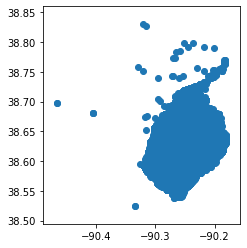

In [7]:
all_crimes = gpd.read_file('temp/crimes_geojson.json')

all_crimes['count'] = all_crimes['count'].astype('int')
all_crimes['date'] = pd.to_datetime(all_crimes['date'])

all_crimes['crime_type'] = all_crimes.crime.str[:2]

all_crimes.plot()

There are crimes that have been given coordinates outside of St. Louis. It's a small number, and it may be intentional.

Now we'll load in the SLMPD concentration areas.

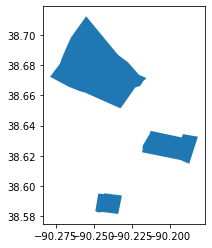

In [8]:
crime_areas = gpd.read_file('crime_areas.json')
crime_areas.plot()

That file includes the original rectangle as well as two new areas of concentration, so we'll drop the other two. We also need to buffer the shape, as I originally drew it just inside the street boundaries. We'll also save that as a geojson file, in case it's helpful later.

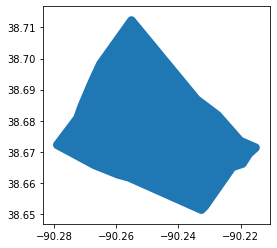

In [9]:
hayden = crime_areas.drop([1,2], axis=0)
buffer = hayden.buffer(.0014)

buffer.plot()

buffer.to_file("temp/hayden-buffered.geojson",driver='GeoJSON')

This buffered area extends slightly beyond the boundaries of the streets that border the rectangle.

## Find out which crimes were reported inside the rectangle

This code adds a boolean column for whether the crime occurred inside the rectangle or not.

In [10]:
in_hayden = all_crimes.intersects(buffer.unary_union)

crimes_in_hayden = all_crimes.copy()

crimes_in_hayden.insert(0,'in_hayden',in_hayden)

crimes_in_hayden.to_csv('temp/out.csv')

We save the data as a csv and re-import it to agate, because I'm more comfortable working inagate than pandas.

In [11]:
def import_geocoded_crimes(file):
    column_names = ['index','in_rectangle','count','crime','date','geometry','crime_category']
    column_types = [number_type,boolean_type,number_type,text_type,datetime_type,text_type,text_type]

    new_table = agate.Table.from_csv(file,column_names,column_types)
    return new_table.select(['in_rectangle','count','crime','date','geometry','crime_category'])

geocoded = import_geocoded_crimes('temp/out.csv')

In [12]:
geocoded.print_table()

| in_rectangle | count | crime  |                date | geometry             | crime_category |
| ------------ | ----- | ------ | ------------------- | -------------------- | -------------- |
|        False |     1 | 142320 | 2017-01-01 00:01:00 | POINT (-90.216280... | 14             |
|        False |     1 | 091114 | 2017-01-01 00:01:00 | POINT (-90.225544... | 09             |
|        False |     1 | 142320 | 2017-01-01 00:01:00 | POINT (-90.207375... | 14             |
|        False |     1 | 071030 | 2017-01-01 00:01:00 | POINT (-90.220741... | 07             |
|        False |     1 | 067601 | 2017-01-01 00:01:00 | POINT (-90.250133... | 06             |
|        False |     1 | 071013 | 2017-01-01 00:01:00 | POINT (-90.214193... | 07             |
|        False |     1 | 265321 | 2017-01-01 00:05:00 | POINT (-90.230171... | 26             |
|         True |     1 | 142320 | 2017-01-01 00:05:00 | POINT (-90.233964... | 14             |
|        False |     1 | 152200 | 2017-0

## Analysis

Next we want to get a broad overview of crimes by year and in/out of the rectangle.

In [16]:
add_year = geocoded.compute([
    ('year', agate.Formula(text_type, lambda r: r['date'].year))
])

grouped = add_year.group_by('year').group_by('in_rectangle')

def pct_chg(row,year1,year2):
    return ((row[year2] - row[year1]) / row[year1]).quantize(Decimal('0.01'))

overview = grouped.aggregate([
    ('total',agate.Sum('count'))
]).pivot('in_rectangle','year', aggregation=agate.Sum('total')).compute([
    ('17-18 %Change', agate.PercentChange('2017','2018')),
    ('18-19 %Change', agate.PercentChange('2018','2019'))
]).compute([
    ('in_rectangle', agate.Formula(text_type, lambda r: str(r['in_rectangle'])))
], replace=True).select(['in_rectangle','2017','2018','17-18 %Change','2019','18-19 %Change'])

totals = overview.aggregate([
    ('2017', agate.Sum('2017')),
    ('2018', agate.Sum('2018')),
    ('2019', agate.Sum('2019'))
])

totals_table = {'in_rectangle':'Total'}
for key,value in totals.items():
    totals_table[key] = value
    
totals_row = agate.Table.from_object([totals_table]).compute([
    ('17-18 %Change', agate.PercentChange('2017','2018')),
    ('18-19 %Change', agate.PercentChange('2018','2019'))
]).select(['in_rectangle','2017','2018','17-18 %Change','2019','18-19 %Change'])

print('*** All crimes ***\n')

agate.Table.merge([overview,totals_row]).compute([
    ('17-18 %Change', agate.Formula(number_type, lambda r: r['17-18 %Change'].quantize(Decimal('0.01')))),
    ('18-19 %Change', agate.Formula(number_type, lambda r: r['18-19 %Change'].quantize(Decimal('0.01'))))
], replace=True).print_table()

*** All crimes ***

| in_rectangle |   2017 |   2018 | 17-18 %Change |   2019 | 18-19 %Change |
| ------------ | ------ | ------ | ------------- | ------ | ------------- |
| False        | 16,108 | 14,742 |         -8.48 | 14,230 |         -3.47 |
| True         |  3,027 |  2,944 |         -2.74 |  2,905 |         -1.32 |
| Total        | 19,135 | 17,686 |         -7.57 | 17,135 |         -3.12 |


We can see the overall number of crimes dropped about 7.6 percent between 2017-2018, and another 3.1 percent between 2018-2019. That drop in crime was largely outside the rectangle.

In [17]:
agg_assault_w_firearm = ["041011","041012","041013","041014","041015","041016","041021","041022","041023","041024","041025","041026","041101","041201","041202","041203"]

# If all robberies should count as violent crimes, use this row instead.
violent = add_year.where(lambda row: row['crime'] in agg_assault_w_firearm or row['crime_category'] in ['01','03'])

grouped = violent.group_by('year').group_by('in_rectangle')

overview = grouped.aggregate([
    ('total',agate.Sum('count'))
]).pivot('in_rectangle','year', aggregation=agate.Sum('total')).compute([
    ('17-18 %Change', agate.PercentChange('2017','2018')),
    ('18-19 %Change', agate.PercentChange('2018','2019'))
]).compute([
    ('in_rectangle', agate.Formula(text_type, lambda r: str(r['in_rectangle'])))
], replace=True).select(['in_rectangle','2017','2018','17-18 %Change','2019','18-19 %Change'])

totals = overview.aggregate([
    ('2017', agate.Sum('2017')),
    ('2018', agate.Sum('2018')),
    ('2019', agate.Sum('2019'))
])

totals_table = {'in_rectangle':'Total'}
for key,value in totals.items():
    totals_table[key] = value
    
totals_row = agate.Table.from_object([totals_table]).compute([
    ('17-18 %Change', agate.PercentChange('2017','2018')),
    ('18-19 %Change', agate.PercentChange('2018','2019'))
]).select(['in_rectangle','2017','2018','17-18 %Change','2019','18-19 %Change'])

print('*** Violent crimes ***\n')

agate.Table.merge([overview,totals_row]).compute([
    ('17-18 %Change', agate.Formula(number_type, lambda r: r['17-18 %Change'].quantize(Decimal('0.01')))),
    ('18-19 %Change', agate.Formula(number_type, lambda r: r['18-19 %Change'].quantize(Decimal('0.01'))))
], replace=True).print_table()

*** Violent crimes ***

| in_rectangle |  2017 |  2018 | 17-18 %Change |  2019 | 18-19 %Change |
| ------------ | ----- | ----- | ------------- | ----- | ------------- |
| False        | 1,282 | 1,131 |        -11.78 | 1,154 |          2.03 |
| True         |   426 |   402 |         -5.63 |   372 |         -7.46 |
| Total        | 1,708 | 1,533 |        -10.25 | 1,526 |         -0.46 |


Just looking at violent crimes, we can see that they dropped more outside the rectangle in 2017-18, but in 2018-19, they dropped by nearly 9 percent inside the rectangle, and rose outside it.

In [19]:
lookup = {'01': 'Homicide', '03': 'Robbery', '04': 'Agg. Assault w/ firearm'}

grouped = violent.group_by('year').group_by('in_rectangle').group_by('crime_category')

print('*** Violent crimes ***\n\n*** Not in rectangle ***\n')

grouped.aggregate([
    ('total',agate.Sum('count'))
]).where(lambda row:row['in_rectangle'] == False).pivot('crime_category','year',aggregation=agate.Sum('total'))\
.order_by('crime_category').compute([
    ('17-18 %Change', agate.PercentChange('2017','2018')),
    ('18-19 %Change', agate.PercentChange('2018','2019'))
]).compute([
    ('crime_category', agate.Formula(text_type, lambda r: lookup[r['crime_category']]))
], replace=True).compute([
    ('17-18 %Change', agate.Formula(number_type, lambda r: r['17-18 %Change'].quantize(Decimal('0.01')))),
    ('18-19 %Change', agate.Formula(number_type, lambda r: r['18-19 %Change'].quantize(Decimal('0.01'))))
], replace=True).select(['crime_category','2017','2018','17-18 %Change','2019','18-19 %Change']).print_table(max_column_width=None)

print('\n\n*** In rectangle ***\n')

grouped.aggregate([
    ('total',agate.Sum('count'))
]).where(lambda row:row['in_rectangle'] == True).pivot('crime_category','year',aggregation=agate.Sum('total'))\
.order_by('crime_category').compute([
    ('17-18 %Change', agate.PercentChange('2017','2018')),
    ('18-19 %Change', agate.PercentChange('2018','2019'))
]).compute([
    ('crime_category', agate.Formula(text_type, lambda r: lookup[r['crime_category']]))
], replace=True).compute([
    ('17-18 %Change', agate.Formula(number_type, lambda r: r['17-18 %Change'].quantize(Decimal('0.01')))),
    ('18-19 %Change', agate.Formula(number_type, lambda r: r['18-19 %Change'].quantize(Decimal('0.01'))))
], replace=True).select(['crime_category','2017','2018','17-18 %Change','2019','18-19 %Change']).print_table(max_column_width=None)

*** Violent crimes ***

*** Not in rectangle ***

| crime_category          | 2017 | 2018 | 17-18 %Change | 2019 | 18-19 %Change |
| ----------------------- | ---- | ---- | ------------- | ---- | ------------- |
| Homicide                |   40 |   40 |          0.00 |   43 |          7.50 |
| Robbery                 |  536 |  409 |        -23.69 |  442 |          8.07 |
| Agg. Assault w/ firearm |  706 |  682 |         -3.40 |  669 |         -1.91 |


*** In rectangle ***

| crime_category          | 2017 | 2018 | 17-18 %Change | 2019 | 18-19 %Change |
| ----------------------- | ---- | ---- | ------------- | ---- | ------------- |
| Homicide                |   25 |   25 |          0.00 |   23 |         -8.00 |
| Robbery                 |   94 |   91 |         -3.19 |   94 |          3.30 |
| Agg. Assault w/ firearm |  307 |  286 |         -6.84 |  255 |        -10.84 |


Outside the rectangle, homicides increased slightly. Robberies declined in 2018 but increased again in 2019. And agg. assault with a firearm decreased slightly both years.

Inside the rectangle, homicides decreased slightly. Robberies remained steady. Aggravated assault with a firearm declined in both years.